# Phân tích yếu tố trung gian (mediator) với dowhy

### BS. Lê Ngọc Khả Nhi

# Nhập đề

Như chúng ta đều biết, cơ thể con người là một hệ thống phức tạp, trong điều kiện sinh lý bình thường hay bệnh lý, những gì biểu hiện ra bên ngoài là kết quả của tương tác giữa nhiều nhân tố khác nhau, bao gồm các loại tế bào và phân tử sinh học mà chúng tổng hợp nên. Một khi xác định được các quy trình và nhân tố tham gia, ta có thể tạo ra các hoạt chất nhắm đến một mục tiêu, cho phép gián đoạn, ức chế hay đảo ngược quy trình bệnh lý này. 

Thí dụ cổ điển: Thuốc Trinitrine có cơ chế trị liệu là tăng sinh tổng hợp nitric oxide nội sinh, phân tử này gây giãn cơ trơn mạch máu, tạo ra hiệu quả hạ huyết áp. Trong thí dụ này, can thiệp trị liệu đưa vào chỉ là nguyên liệu (tiền chất), nhưng cần phải có quy trình sinh tổng hợp NO của tế bào nội mạc (ở cấp độ protein, hay gène) để enzyme NO synthase (NOS) chuyển hóa arginine thành NO, và NO gây tác động giãn cơ trên tế bào cơ trơn. Như vậy, hiệu quả điều trị (huyết áp giảm) mà ta quan sát được là kết quả của một chuỗi những nhân tố trung gian (tế bào nội mô, enzyme NOS, các receptor và effector của NO trên tế bào cơ trơn...). 

Vì vậy, phân tích vai trò của những yếu tố trung gian là một nhu cầu quan trọng trong nghiên cứu Y học, nhất là sinh lý học phân tử. Suy luận nhân quả cho phép trả lời câu hỏi này qua khái niệm phân tích nhân tố trung gian (Mediator) hay hiệu ứng trung gian (Mediation).

Trong bài thực hành hôm nay, Nhi sẽ trình diễn tính năng phân tích hiệu ứng trung gian bằng package dowhy cho Python, thông qua một bài toán mô phỏng

In [1]:
warning_status = "ignore"
import warnings
warnings.filterwarnings(warning_status)

with warnings.catch_warnings():
    warnings.filterwarnings(warning_status, category=DeprecationWarning)
    warnings.filterwarnings(warning_status, category=UserWarning)

# Đồ họa

import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz/bin/'

import matplotlib.pyplot as plt
import seaborn as sns

from causalgraphicalmodels import CausalGraphicalModel


# Package dowhy
from dowhy import CausalModel
import dowhy.datasets


# GLM
from patsy import dmatrices
import statsmodels.formula.api as smf

# Tools
from itertools import product

import numpy as np
import pandas as pd

# Tạo dữ liệu mô phỏng

Nhi viết hàm để mô phỏng một dữ liệu theo quy luật như sau:

Một nghiên cứu quan sát gồm 4 biến W1,W2,W3,W4 định lượng, 1 outcome Y định lượng, 1 can thiệp T nhị phân và yếu tố trung gian M định lượng.

Trong số 4 biến W1,W2,W3,W4, có 3 biến là confounder, chúng tác động lên propensity score (chỉ định điều trị T) theo quy luật tuyến tính, đồng thời cũng ảnh hưởng lên outcome Y (do đó 3 biến này còn được gọi là Common cause).

Can thiệp T_bin là 1 biến nhị phân (có/không điều trị), giá trị Có/không dựa vào propensity score T, vốn phụ thuộc vào 3 common cause variable W kể trên. T gây 1 hiệu ứng liều/đáp ứng Te theo hàm sigmoid lên giá trị mediator M.

Mediator M là một biến định lượng, giá trị M phụ thuộc vào hiệu ứng Te (hàm sigmoid), đồng thời phụ thuộc 3 common causes W. M gây hiệu ứng lên Outcome Y. Trong dowhy, M còn có tên gọi là front door variable.

Outcome Y là một biến định lượng, giá trị Y phụ thuộc vào 3 confounders W, mediator M (hiệu ứng gián tiếp - indirect treatment effect) và một phần Te (hiệu ứng trực tiếp - direct treatment effect).

Hàm mô phỏng xuất ra kết quả là 1 dictionary, trong đó có datafame chứa dữ liệu, 1 sơ đồ nhân quả dưới định dạng digraph, tên các nhân tố: treatment, common cause, frontdoor, và outcome; cấu trúc này tương thích với input data của dowhy.

In [2]:
def simulate_data(n = 3000, n_w = 4, support_size = 2, n_x = 1):
    
    def exp_xe(x):
        return 1/(1 + np.exp(5 - x[0]))

    np.random.seed(123)

    support_M = np.random.choice(np.arange(n_w), size=support_size, replace=False)
    coefs_M = np.random.uniform(1,3, size=support_size)
    intercept_M = np.random.normal(2,0.5, n)
    eta_M = lambda n: np.random.normal(0,2.5, size=n)

    support_T = support_M

    intercept_T = np.random.normal(0, 2.6, n)
    coefs_T = np.random.uniform(1,3.5, size=support_size)
    eta_T = lambda n: np.random.normal(0,2.4, size=n)

    eta_sample = lambda n: np.random.normal(0, 0.25, size=n)

    W = np.random.gamma(0.5, 2.7, size=(n, n_w))
    X = np.random.gamma(1, 1.7, size=(n, n_x))

    TE = np.array([exp_xe(x_i) for x_i in X])
    T = intercept_T + np.dot(W[:, support_T], coefs_T) + eta_T(n)

    T_bin = (T >= np.median(T))*1

    M = TE * T + np.dot(W[:, support_M], coefs_M) + eta_M(n)

    coefs_Y = np.random.uniform(0,1,size=support_size)
    coefs_Ie = np.random.normal(3.2,1.2,n)
    coefs_Me = np.random.normal(0.5,0.2,n)
    coefs_Te = np.random.normal(2.3,0.8,n)
    
    eta_Y = lambda n: np.random.normal(0,1.8, size=n)
    
    Y = coefs_Ie*M*T_bin + coefs_Te*T + coefs_Me*M + np.dot(W[:, support_M], coefs_Y) + eta_Y(n)
    
    df1 = pd.DataFrame({'M': M.flatten(),
                        'Y': Y.flatten(),
                        'T': T_bin.flatten().astype('bool'),
                        })
    
    df2 = pd.DataFrame(W, columns = [f'W{i+1}' for i in range(n_w)])
    
    df = pd.concat([df1,df2], axis = 1, sort= False)
    
    supports = [f'W{i+1}' for i in support_T]
    
    indep = list(df2.drop(supports, axis = 1).columns)
    
    # g = 'digraph {U[label="Unobs Conf"]; U->T; U->Y; M->Y; T->M'
    g = 'digraph {M->Y; T->M'

    for w in supports:
        g += f"; {w}->T"
        g += f"; {w}->Y"
    g += '}'
    
    return {'df': df,
            'treatment_name': 'T',
            'outcome_name': 'Y',
            'common_causes_names': supports,
            'frontdoor_variables_names': ['M'],
            'graph': g
           }

Nhi sử dụng hàm mô phỏng trên để tạo ra object data:

In [3]:
data = simulate_data(n = 3000,
                     n_w = 4, 
                     support_size = 3, 
                     n_x = 1)

Đây là dataframe

In [4]:
df = data['df']

df

,M,Y,T,W1,W2,W3,W4
0,23.504514,200.431931,True,0.200583,2.718954,3.326662e-01,7.991829
1,3.599651,-5.930982,False,0.000003,0.279515,3.458496e+00,0.153272
2,5.100731,5.441458,False,0.082579,0.878289,5.755800e-08,0.026754
3,6.855699,40.584146,True,0.963301,2.130424,5.999213e-01,0.372489
4,34.111988,160.931035,True,3.450023,0.004325,1.144078e+01,3.576866
...,...,...,...,...,...,...,...
2995,2.949806,-12.107374,False,0.622858,0.114351,6.835252e+00,0.117040
2996,1.093949,9.973563,False,0.541619,1.424755,9.926663e-01,0.028678
2997,10.304702,56.607833,True,1.132162,4.219154,4.275318e+00,0.087838
2998,3.531946,19.830106,False,1.108893,0.064680,8.956397e-01,0.098870


Tên các thành phần trong data:

In [5]:
data['treatment_name'], \
data['outcome_name'], \
data['common_causes_names'], \
data['frontdoor_variables_names']

('T', 'Y', ['W4', 'W1', 'W2'], ['M'])

Nhi viết 1 hàm khác để biến nội dung object data này thành 1 causal diagram

In [6]:
def caudal_diagram(data: dict):
    
    edges = []
    
    for j in product(data['frontdoor_variables_names'], data['outcome_name']):
        edges += [j]
    
    for j in product(data['common_causes_names'], data['outcome_name']):
        edges += [j]
        
    for j in product(data['common_causes_names'], data['treatment_name']):
        edges += [j]
    
    edges += [(data['treatment_name'], data['frontdoor_variables_names'][0])]
    
    model_obs = CausalGraphicalModel(nodes= [i for i in data['df'].columns],
                                     edges = edges)
    

    return model_obs

Đây là nội dung sơ đồ nhân quả (Causal diagram) mà ta sẽ sử dụng trong phân tích mediation

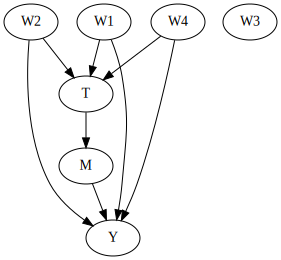

In [7]:
cdg = caudal_diagram(data)

cdg.draw()

# Thăm dò dữ liệu

Ta sẽ vẽ một số biểu đồ để thăm dò trực quan dữ liệu

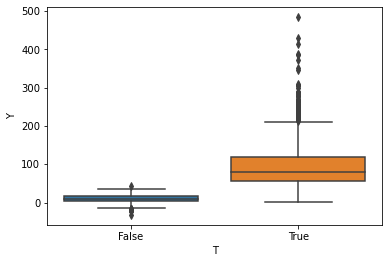

In [8]:
sns.boxplot(data = df, x = 'T', y = 'Y')

Như ta thấy, Y cao hơn ở nhóm có can thiệp so với nhóm không can thiệp, đây là hiệu ứng tổng quát hay toàn thể (total treatment effect).

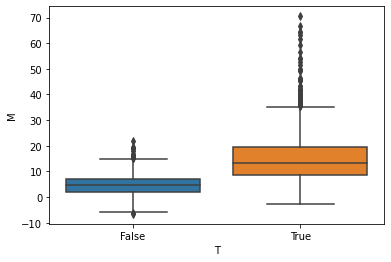

In [9]:
sns.boxplot(data = df, x = 'T', y = 'M')

Mặt khác, giá trị M cao hơn ở nhóm có can thiệp so với nhóm không can thiệp

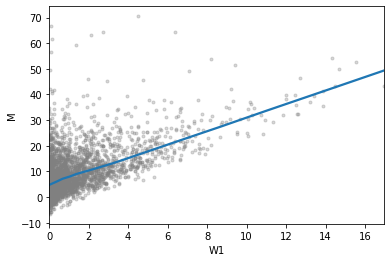

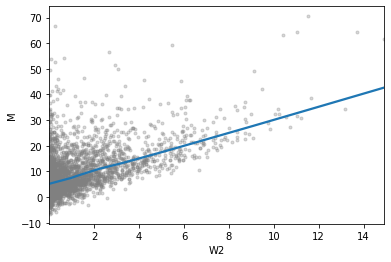

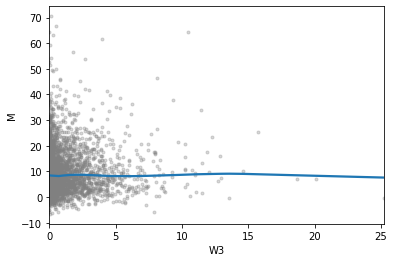

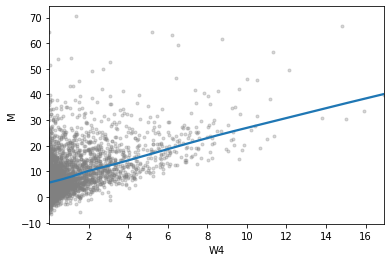

In [11]:
for w in [f"W{i+1}" for i in range(4)]:
    sns.regplot(x=df[w], 
        y=df['M'],
        lowess = True, marker = ".",
        scatter_kws={'alpha':0.3, 'color':'grey'})
    plt.show()

Như dự kiến, có 3 confounders là W1, W2 và W4, trong khi W3 hoàn toàn độc lập với M

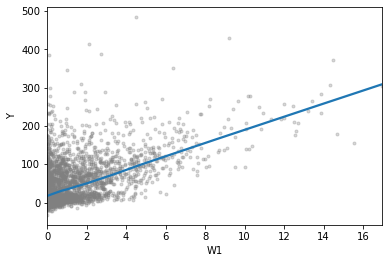

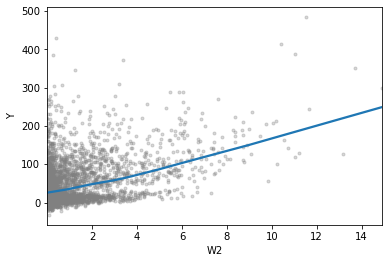

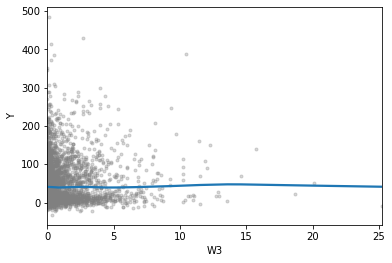

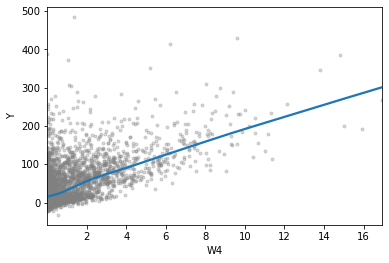

In [12]:
for w in [f"W{i+1}" for i in range(4)]:
    sns.regplot(x=df[w], 
        y=df['Y'],
        lowess = True, marker = ".",
        scatter_kws={'alpha':0.3, 'color':'grey'})
    plt.show()

Tương tự, ta thấy 3 confounders là W1, W2 và W4 có tương quan với Y, trong khi W3 cũng hoàn toàn độc lập với Y

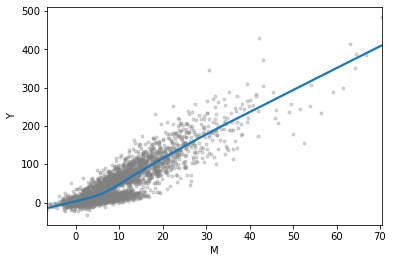

In [13]:
sns.regplot(x=df['M'], 
            y=df['Y'],
            lowess = True, marker = ".",
            scatter_kws={'alpha':0.3, 'color':'grey'})

Ta lại thấy rằng Y có tương quan thuận với M, tuy nhiên hiệu ứng của M lên Y lại có tương tác với T, cụ thể, khi có can thiệp T, hiệu ứng M lên Y mạnh hơn, so với khi không có can thiệp.

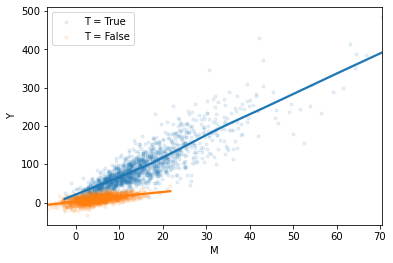

In [20]:
for i in [True, False]:
    temp_df = df.query(f'T == {i}')
    sns.regplot(x=temp_df['M'], 
                    y=temp_df['Y'],
            lowess = True, marker = ".",
            scatter_kws={'alpha':0.1},
            label = f"T = {i}")
    plt.legend()

# Hệ thống mô hình tuyến tính

Nếu không có sơ đồ nhân quả dẫn đường, mà chỉ có dữ liệu, cách làm thông thường là dựng một mô hình tuyến tính đa biến để phân tích hiệu ứng của M, T, W1, W2... lên Y, với kết quả như sau:

In [25]:
formula = "Y ~ T + M + W1 + W2 + W4"

smf.glm(formula, df).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                      Y   No. Observations:                 3000
Model:                            GLM   Df Residuals:                     2994
Model Family:                Gaussian   Df Model:                            5
Link Function:               identity   Scale:                          463.71
Method:                          IRLS   Log-Likelihood:                -13463.
Date:                Sun, 29 Nov 2020   Deviance:                   1.3884e+06
Time:                        10:34:50   Pearson chi2:                 1.39e+06
No. Iterations:                     3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -15.1747      0.635    -23.880      0.000     -16.420     -13.929
T[T.True]     29.9066      1.022     29.249      0.000      27.903      31.911
M              3.1941      0.111     28.813      0.000       2.977       3.411
W1             5.2383      0.358     14.632      0.000       4.537       5.940
W2             2.7630      0.366      7.554      0.000       2.046       3.480
W4             7.0906      0.343     20.648      0.000       6.418       7.764
==============================================================================
"""

Hoặc như sau:

In [26]:
formula = "Y ~ T * M + W1 + W2 + W4"

smf.glm(formula, df).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                      Y   No. Observations:                 3000
Model:                            GLM   Df Residuals:                     2993
Model Family:                Gaussian   Df Model:                            6
Link Function:               identity   Scale:                          380.65
Method:                          IRLS   Log-Likelihood:                -13166.
Date:                Sun, 29 Nov 2020   Deviance:                   1.1393e+06
Time:                        10:34:54   Pearson chi2:                 1.14e+06
No. Iterations:                     3                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      -0.6869      0.808     -0.851      0.395      -2.270       0.896
T[T.True]       8.6741      1.244      6.974      0.000       6.236      11.112
M               0.5610      0.144      3.900      0.000       0.279       0.843
T[T.True]:M     3.4874      0.136     25.580      0.000       3.220       3.755
W1              4.0502      0.328     12.361      0.000       3.408       4.692
W2              2.2181      0.332      6.679      0.000       1.567       2.869
W4              5.8522      0.315     18.585      0.000       5.235       6.469
===============================================================================
"""

Cách làm "mù" này có thể dẫn đến kết quả sai lầm, cách làm đúng sẽ được trình bày sau đây:

# Sử dụng dowhy cho phân tích mediation

## Bước 1: Đóng gói mô hình nhân quả

Ta dùng CausalModel trong dowhy để khởi tạo 1 class mô hình nhân quả như sau:

In [ ]:
model = CausalModel(data['df'],
                    data["treatment_name"],
                    data["outcome_name"],
                    data['graph'])

INFO:dowhy.causal_graph:Using Matplotlib for plotting


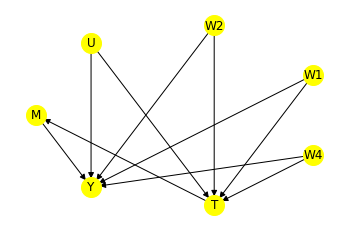

In [29]:
model.view_model()

Lưu ý: so với sơ đồ nhân quả ban đầu, dowhy tự động thêm vào 1 node U, gọi là Unobserved common cause, đây là 1 giả định cho tất cả mô hình của dowhy, cho rằng luôn có 1 confouder U không tồn tại trong dữ liệu.

## Ước lượng hiệu ứng trực tiếp và gián tiếp

Mục tiêu của phân tích nhân tố trung gian hay hiệu ứng trung gian, nhằm ước lượng 2 bộ phận của hiệu ứng toàn thể (Total treatment effect), là hiệu ứng trực tiếp (direct treatment effect, theo con đường T -> Y) và gián tiếp (indirect treatment effect, theo con đường T -> M -> Y).

Package dowhy áp dụng quy trình suy luận nhân quả theo Judea Pearl đề xuất, đầu tiên, cần có sơ đồ nhân quả (causal diagram), sau đó, xác định các yếu tố cần ước lượng (Estimand), rồi mới tiến hành ước lượng (Estimate).

Ta sẽ lần lượt thi hành bước 2 (Estimand) cho 2 loại hiệu ứng: Direct và Indirect:

### Estimand direct effect

In [35]:
identified_estimand_nde = model.identify_effect(estimand_type="nonparametric-nde", 
                                                proceed_when_unidentifiable=True)

INFO:dowhy.causal_identifier:Continuing by ignoring these unobserved confounders because proceed_when_unidentifiable flag is True.
INFO:dowhy.causal_identifier:Mediators for treatment and outcome:['M']
INFO:dowhy.causal_identifier:All common causes are observed. Causal effect can be identified.
INFO:dowhy.causal_identifier:All common causes are observed. Causal effect can be identified.


In [36]:
identified_estimand_nde.estimand_type

'nonparametric-nde'

In [37]:
identified_estimand_nde.estimands

{'mediation': {'estimand': Expectation(Derivative(Y, [M])*Derivative([M], [T])),
  'assumptions': {'Mediation': 'M intercepts (blocks) all directed paths from T to Y except the path {T}→{Y}.',
   'First-stage-unconfoundedness': 'If U→{T} and U→{M} then P(M|T,U) = P(M|T)',
   'Second-stage-unconfoundedness': 'If U→{M} and U→{Y} then P(Y|M, T, U) = P(Y|M, T)'}}}

In [38]:
print(identified_estimand_nde)

Estimand type: nonparametric-nde

### Estimand : 1
Estimand name: mediation
Estimand expression:
Expectation(Derivative(Y, [M])*Derivative([M], [T]))
Estimand assumption 1, Mediation: M intercepts (blocks) all directed paths from T to Y except the path {T}→{Y}.
Estimand assumption 2, First-stage-unconfoundedness: If U→{T} and U→{M} then P(M|T,U) = P(M|T)
Estimand assumption 3, Second-stage-unconfoundedness: If U→{M} and U→{Y} then P(Y|M, T, U) = P(Y|M, T)



### Estimand indirect effect

In [ ]:
identified_estimand_nie = model.identify_effect(estimand_type="nonparametric-nie", 
                                            proceed_when_unidentifiable=True)

In [41]:
identified_estimand_nie.estimands

{'mediation': {'estimand': '',
  'assumptions': {'Mediation': 'M intercepts (blocks) all directed paths from T to Y except the path {T}→{Y}.',
   'First-stage-unconfoundedness': 'If U→{T} and U→{M} then P(M|T,U) = P(M|T)',
   'Second-stage-unconfoundedness': 'If U→{M} and U→{Y} then P(Y|M, T, U) = P(Y|M, T)'}}}

In [40]:
print(identified_estimand_nie)

Estimand type: nonparametric-nie

### Estimand : 1
Estimand name: mediation
Estimand expression:

Estimand assumption 1, Mediation: M intercepts (blocks) all directed paths from T to Y except the path {T}→{Y}.
Estimand assumption 2, First-stage-unconfoundedness: If U→{T} and U→{M} then P(M|T,U) = P(M|T)
Estimand assumption 3, Second-stage-unconfoundedness: If U→{M} and U→{Y} then P(Y|M, T, U) = P(Y|M, T)



## Ước lượng hiệu ứng trực tiếp

In [ ]:
import dowhy.causal_estimators.linear_regression_estimator
causal_estimate_nde = model.estimate_effect(identified_estimand_nde,
                                        method_name="mediation.two_stage_regression",
                                       confidence_intervals=True,
                                       test_significance=False,
                                        method_params = {
                                            'first_stage_model': dowhy.causal_estimators.linear_regression_estimator.LinearRegressionEstimator,
                                            'second_stage_model': dowhy.causal_estimators.linear_regression_estimator.LinearRegressionEstimator
                                        }
                                       )

In [44]:
causal_estimate_nde.interpret()

Increasing the treatment variable(s) [T] from 0 to 1 causes an increase of 33.153666262599856 in the expected value of the outcome [Y], over the data distribution/population represented by the dataset.


Kết quả cho thấy: bộ phận hiệu ứng trực tiếp trung bình (avegraged direct treatment effect) được ước lượng = 33.15, tức là khác biệt trung bình giữa có và không có điều trị T là 33.15 đơn vị Y.

In [45]:
print(causal_estimate_nde)

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-nde

### Estimand : 1
Estimand name: mediation
Estimand expression:
Expectation(Derivative(Y, [M])*Derivative([M], [T]))
Estimand assumption 1, Mediation: M intercepts (blocks) all directed paths from T to Y except the path {T}→{Y}.
Estimand assumption 2, First-stage-unconfoundedness: If U→{T} and U→{M} then P(M|T,U) = P(M|T)
Estimand assumption 3, Second-stage-unconfoundedness: If U→{M} and U→{Y} then P(Y|M, T, U) = P(Y|M, T)

## Realized estimand
(b: M~T) * (b: Y~M+W2+W4+T+W1)
Target units: ate

## Estimate
Mean value: 33.153666262599856
Standard error: 2.6210897972482554
95.0% confidence interval: (30.156935972178587, 38.734687962450145)



Phân tích sâu hơn, ta sẽ hiểu cơ chế đằng sau của việc ước lượng này, đó là dowhy dựng 2 mô hình tuyến tính: M ~ T và Y~M+W2+W4+T+W1, sau đó tính ATE = tích 2 hệ số hồi quy b1 của T và b2 của M với nhau.

Khoảng tin cậy 95% (dùng bootstrap ?) là 30.16 đến 38.73

Ta kiểm tra lại một cách thủ công bằng 2 mô hình GLM như trên:

In [46]:
formula = "M ~ T"

smf.glm(formula, df).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                      M   No. Observations:                 3000
Model:                            GLM   Df Residuals:                     2998
Model Family:                Gaussian   Df Model:                            1
Link Function:               identity   Scale:                          52.400
Method:                          IRLS   Log-Likelihood:                -10194.
Date:                Sun, 29 Nov 2020   Deviance:                   1.5710e+05
Time:                        10:54:57   Pearson chi2:                 1.57e+05
No. Iterations:                     3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      4.8009      0.187     25.686      0.000       4.435       5.167
T[T.True]     10.3796      0.264     39.269      0.000       9.862      10.898
==============================================================================
"""

In [47]:
formula = "Y~M+W2+W4+T+W1"

smf.glm(formula, df).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                      Y   No. Observations:                 3000
Model:                            GLM   Df Residuals:                     2994
Model Family:                Gaussian   Df Model:                            5
Link Function:               identity   Scale:                          463.71
Method:                          IRLS   Log-Likelihood:                -13463.
Date:                Sun, 29 Nov 2020   Deviance:                   1.3884e+06
Time:                        10:55:25   Pearson chi2:                 1.39e+06
No. Iterations:                     3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -15.1747      0.635    -23.880      0.000     -16.420     -13.929
T[T.True]     29.9066      1.022     29.249      0.000      27.903      31.911
M              3.1941      0.111     28.813      0.000       2.977       3.411
W2             2.7630      0.366      7.554      0.000       2.046       3.480
W4             7.0906      0.343     20.648      0.000       6.418       7.764
W1             5.2383      0.358     14.632      0.000       4.537       5.940
==============================================================================
"""

Kết quả đúng bằng 33.15

In [48]:
10.3796 * 3.1941

# Ước lượng hiệu ứng gián tiếp

In [ ]:
causal_estimate_nie = model.estimate_effect(identified_estimand_nie,
                                        method_name="mediation.two_stage_regression",
                                       confidence_intervals=True,
                                       test_significance=False,
                                        method_params = {
                                            'first_stage_model': dowhy.causal_estimators.linear_regression_estimator.LinearRegressionEstimator,
                                            'second_stage_model': dowhy.causal_estimators.linear_regression_estimator.LinearRegressionEstimator
                                        }
                                           )

In [50]:
causal_estimate_nie.interpret()

Increasing the treatment variable(s) [T] from 0 to 1 causes an increase of -1.8974140233178076 in the expected value of the outcome [Y], over the data distribution/population represented by the dataset.


In [51]:
print(causal_estimate_nie)

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-nie

### Estimand : 1
Estimand name: mediation
Estimand expression:

Estimand assumption 1, Mediation: M intercepts (blocks) all directed paths from T to Y except the path {T}→{Y}.
Estimand assumption 2, First-stage-unconfoundedness: If U→{T} and U→{M} then P(M|T,U) = P(M|T)
Estimand assumption 3, Second-stage-unconfoundedness: If U→{M} and U→{Y} then P(Y|M, T, U) = P(Y|M, T)

## Realized estimand
b: Y~T+W2+W4+W1-(b: M~T) * (b: Y~M+W2+W4+T+W1)
Target units: ate

## Estimate
Mean value: -1.8974140233178076
Standard error: 3.1597905946747087
95.0% confidence interval: (-6.8928432237430854, 3.692059806641698)



Kết quả cho thấy ATE gián tiếp (indirect treatment effect) được ước lượng = -1.897; tuy nhiên khoảng tin cậy gồm zero, do đó không có ý nghĩa thống kê.

Phân tích cơ chế, ta thấy ATE indirect là kết quả từ 3 mô hình GLM riêng biệt:

1) Y~T+W2+W4+W1

2) M~T

3) Y~M+W2+W4+T+W1

Indirect ATE = b1 - b2 * b3

Nói cách khác, mô hình b2 và b3 chính là để ước lượng hiệu ứng trực tiếp, còn mô hình b1 để ước lượng hiệu ứng toàn thể (không chứa M), và hiệu ứng gián tiếp chính là phần còn lại của hiệu ứng toàn thể trừ đi hiệu ứng trực tiếp.

Ta có thể kiểm tra thủ công lại và thấy kết quả đúng = -1.89

In [53]:
formula = "Y~T+W2+W4+W1"

smf.glm(formula, df).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                      Y   No. Observations:                 3000
Model:                            GLM   Df Residuals:                     2995
Model Family:                Gaussian   Df Model:                            4
Link Function:               identity   Scale:                          592.09
Method:                          IRLS   Log-Likelihood:                -13830.
Date:                Sun, 29 Nov 2020   Deviance:                   1.7733e+06
Time:                        11:03:32   Pearson chi2:                 1.77e+06
No. Iterations:                     3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -15.5089      0.718    -21.602      0.000     -16.916     -14.102
T[T.True]     31.2563      1.154     27.081      0.000      28.994      33.518
W2            10.9469      0.260     42.034      0.000      10.437      11.457
W4            14.1526      0.272     52.070      0.000      13.620      14.685
W1            13.3424      0.250     53.313      0.000      12.852      13.833
==============================================================================
"""

In [54]:
31.2563 - 10.3796 * 3.1941

## Kết luận

Qua thí dụ minh họa này, ta thấy mặc dù hoàn toàn có thể dùng thống kê cổ điển với 3 mô hình GLM để ước tính thủ công hiệu ứng điều trị của can thiệp T lên outcome Y trong một hệ thống tương đối phức tạp bao gồm 1 Mediator M, tuy nhiên nếu không có sơ đồ nhân quả định hướng, ta không bao giờ đi đến giải pháp đúng (nội dung của 3 mô hình đó là gì ?).

dowhy là ứng dụng duy nhất hiện nay cho phép tự động hóa quy trình suy diễn nhân quả của Pearl. Package này đã giản lược tối đa những biến đổi trên causal diagram, theo lý thuyết của Pearl, để tự động xác định vai trò từng biến, liên hệ giữa chúng, từ đó xây dựng chính xác các mô hình và xuất ra kết quả luôn cho chúng ta.

Tạm biệt và hẹn gặp lại các bạn.